In [1]:
# Define ticket
ticket = 'META'

# Use a new working directory for relative imports
from sys import path
import os

os.chdir(os.path.dirname(path[0]))
# print("New Working Directory " , os.getcwd())

In [2]:
from day_trading.files import DayTradingFiles
from day_trading.dataset import DayTradingDataset
from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pandas as pd
import os

# Prepare the models, targets, and features
files = DayTradingFiles()
dataset = DayTradingDataset()

(
    features_train_df, label_close_train,
    features_test_df, label_close_test
) = dataset.test_train_split(ticket, 'long')


close_model = CatBoostClassifier()

# Train the models
close_model.fit(features_train_df, label_close_train, verbose=False)

num_train_samples = features_train_df.shape[0]
num_test_samples = features_test_df.shape[0]
print(f'Training distribution: 0 ({(num_train_samples - sum(label_close_train))*100/num_train_samples:0.2f}%) - 1 ({sum(label_close_train)*100/num_train_samples:0.2f}%)')
print(f'Validation distribution: 0 ({(num_test_samples - sum(label_close_test))*100/num_test_samples:0.2f}%) - 1 ({sum(label_close_test)*100/num_test_samples:0.2f}%)')

print(features_test_df.head(10))

Getting the data for the ticket
Getting data for META
Convert the HTTP response into a pandas DataFrame
Processing data for META
Processing data for META
Processing data for META
There are 6951 data points.
Calculating the cummulative features.
Defining the targets.
# Samples with NaN: 6951
# Samples without NaN: 6888
Two weeks ago: 2022-11-04 01:58:08.474250
Defining the training data.
Defining the test data.
Training distribution: 0 (91.21%) - 1 (8.79%)
Validation distribution: 0 (86.12%) - 1 (13.88%)
           high        low      close       open   volume  day_of_week  hour  \
6170  91.389999  89.449997  89.519997  90.349998  3625744            4    13   
6171  90.019997  89.320000  89.889999  89.500000  1108437            4    13   
6172  89.786797  88.680000  88.680000  89.750000  1424290            4    13   
6173  89.079903  88.330002  88.440002  88.500000  1360099            4    13   
6174  88.900002  88.345001  88.884003  88.500000  2009649            4    13   
6175  89.69

In [3]:
import numpy as np

"""
# Feature importance
sorted_idx = np.argsort(close_model.coef_)[::-1][0]
print(f'Feature Importance:')
for index in sorted_idx:
    print([features_train_df.columns[index], close_model.coef_[0][index]])

"""
sorted_idx = np.argsort(close_model.feature_importances_)[::-1]
print(f'Feature Importance:')
for index in sorted_idx:
    print([features_test_df.columns[index], close_model.feature_importances_[index]])


Feature Importance:
['hour', 9.921472164168312]
['minute', 7.239636980758841]
['volume', 6.403479024188412]
['Volatility_close_15', 3.439998578094153]
['Volatility_close_6', 3.250072432729325]
['Volatility_close_9', 2.782677019710563]
['MACD_Signal', 2.739646126308366]
['VWAP', 2.5338585566465537]
['Volatility_close_12', 2.5325132909169596]
['P_Delta_Close_9', 2.446121771429246]
['P_Delta_Close_16', 2.2976083611660263]
['P_Delta_Close_6', 2.2928726383005795]
['P_Delta_Close_13', 2.22946664546961]
['P_Delta_Close_10', 2.0880729537057188]
['P_Delta_Close_8', 2.078785920584342]
['P_Delta_Close_2', 2.077721562308857]
['P_Delta_Close_12', 2.0159316011488575]
['P_Delta_Close_18', 1.9830695173841548]
['P_Delta_Close_15', 1.864689321336259]
['P_Delta_Close_7', 1.8524971500268466]
['P_Delta_Close_19', 1.8372202219684526]
['P_Delta_Close_20', 1.785774375871712]
['MACD', 1.7420191215838268]
['RSI', 1.7161136696881896]
['P_Delta_Close_11', 1.6985295754624925]
['MACD_Histogram', 1.6977367574307565]

In [4]:
# Make predictions
close_predictions = close_model.predict(features_test_df)

print(f'Sample Predictions: {close_predictions[:20]}')

Sample Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Precision: 0.3333333333333333
Recall: 0.05555555555555555
Accuracy: 0.8534704370179949
F1-Score: 0.09523809523809525
Confusion Matrix:
 [[658  12]
 [102   6]]


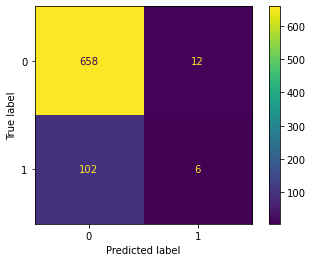

In [5]:
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    confusion_matrix, f1_score, ConfusionMatrixDisplay
)

print(f'Precision: {precision_score(label_close_test, close_predictions)}')
print(f'Recall: {recall_score(label_close_test, close_predictions)}')
print(f'Accuracy: {accuracy_score(label_close_test, close_predictions)}')
print(f'F1-Score: {f1_score(label_close_test, close_predictions)}')
print(f'Confusion Matrix:\n {confusion_matrix(label_close_test, close_predictions)}')
cm_display = ConfusionMatrixDisplay(confusion_matrix(label_close_test, close_predictions)).plot()